In [2]:
%reload_ext autoreload
%autoreload 2

import pickle

from utils.utils import split_csv

from preprocessing.cleaning import get_cleaned_data
from preprocessing.encoding import encode_data

from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from exploration.midterm_exploration import plot_feature_against_diagnosis
from exploration.feature_selection_plots import plot_mrmr_and_rf

from modeling.mrmr_feature_selection import plot_cutoffs
from modeling.logistic import run_elastic_net, evaluate_results
from modeling.RandomForest import run_random_forest, evaluate_random_forest
from modeling.mlp import run_mlp, evaluate_mlp
from modeling.comparisons import plot_f1_scores


## Constants for the label

In [3]:
LABEL = "P1_PT_TYPE"
AD = 1
CN = 2
MCI = 4

## Clean, encode, and partition the data into blood, clinical, and combined dataframes

In [4]:
df = encode_data(get_cleaned_data())
combined, blood_only, clinical_only_mci = split_csv(df)
clinical_only = clinical_only_mci[clinical_only_mci[LABEL] != MCI]

## Plot some initial exploratory visualizations

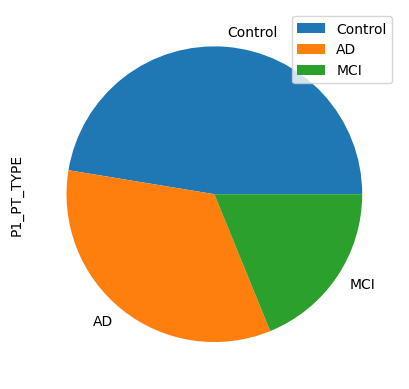

In [5]:
plot_labels_pie_chart(df)

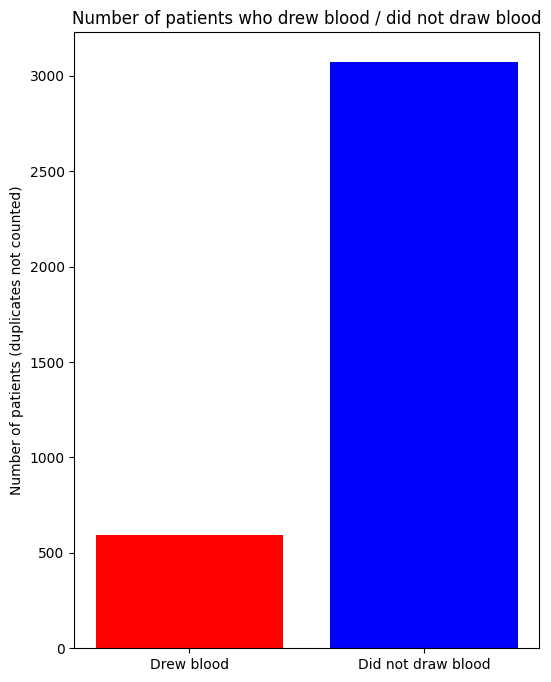

In [6]:
plot_blood_draw_statistics(df)

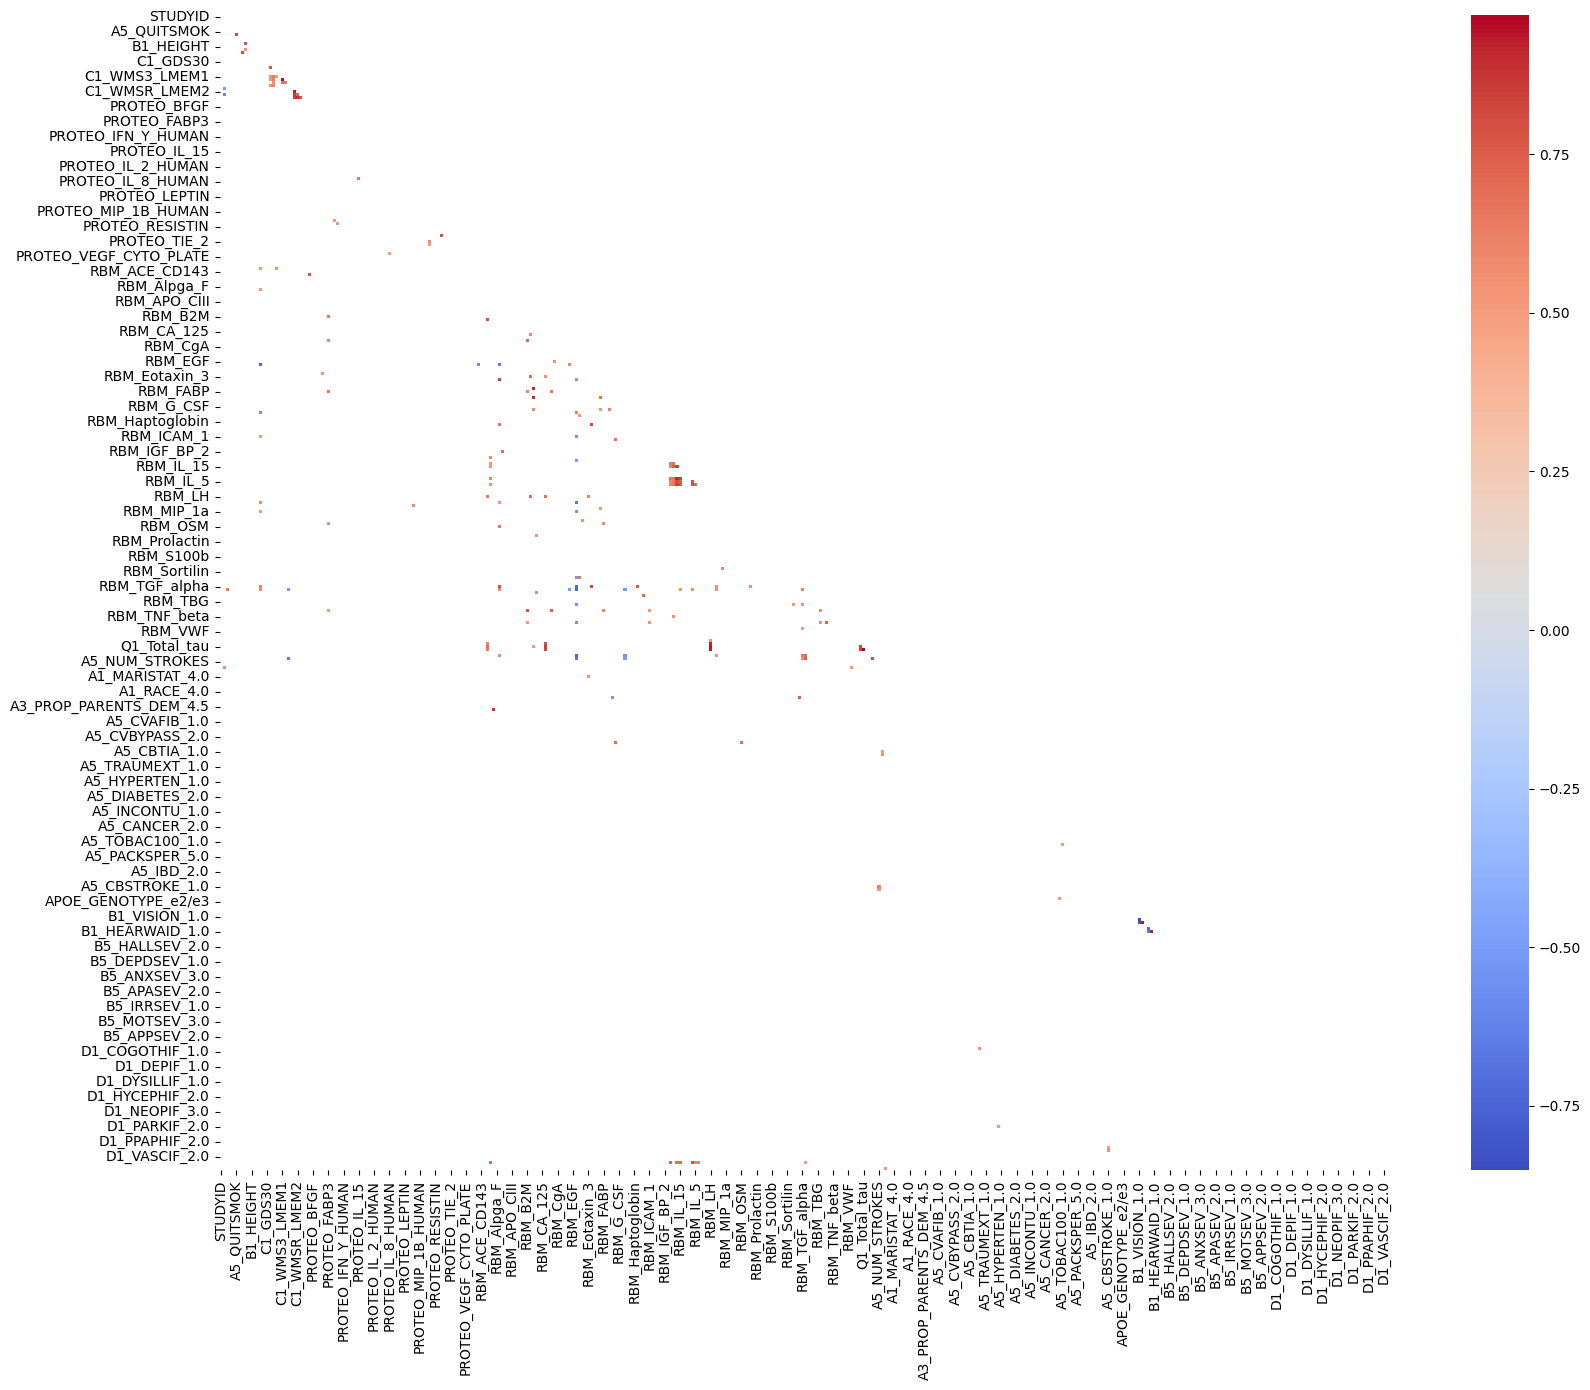

In [7]:
plot_correlations(df)

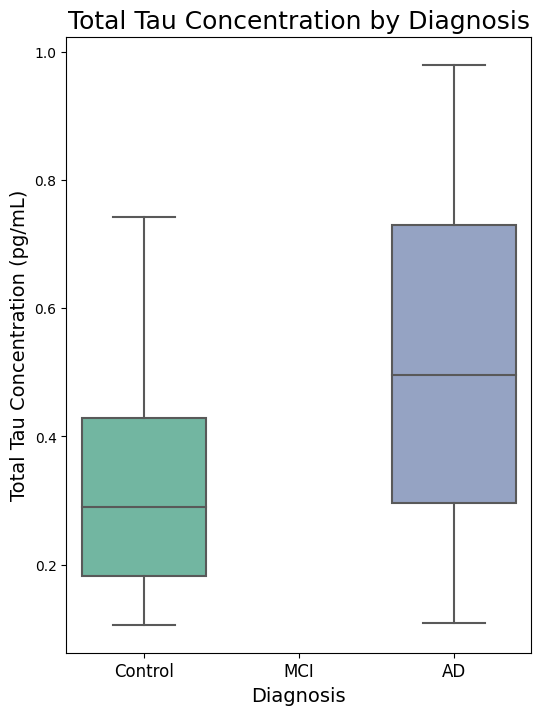

In [8]:
plot_feature_against_diagnosis(
    blood_only,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png="Total Tau Concentration by Diagnosis"
)

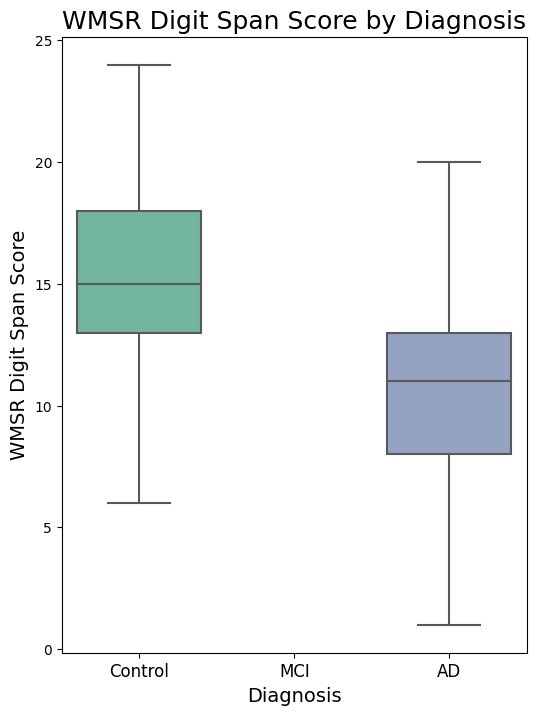

In [9]:
plot_feature_against_diagnosis(
    clinical_only,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png="WMSR Digit Span Score by Diagnosis"
)

## Run MRMR feature selection to pick features for each of the partitions

100%|██████████| 327/327 [00:29<00:00, 11.27it/s]


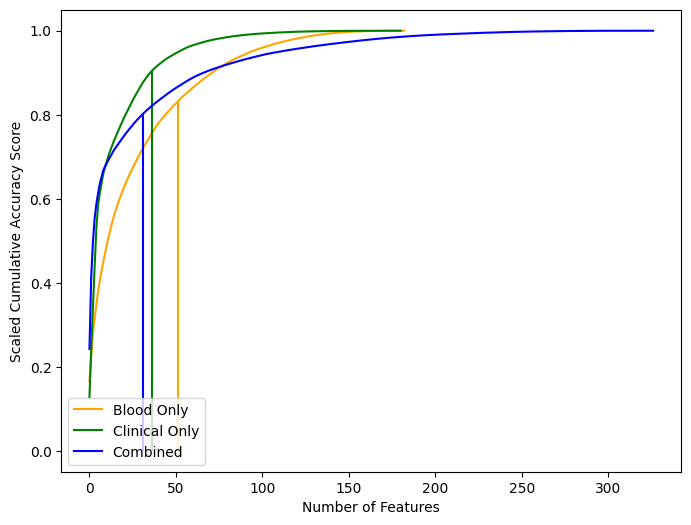

In [10]:
blood_features, clinical_features, combined_features, blood_mrmr_scores, clinical_mrmr_scores, combined_mrmr_scores = plot_cutoffs(blood_only, clinical_only, combined)
blood_only_subset = blood_only[blood_features + [LABEL]]
clinical_only_subset = clinical_only[clinical_features + [LABEL]]
combined_subset = combined[combined_features + [LABEL]]
clinical_only_subset_mci = clinical_only_mci[clinical_features + [LABEL]]

## Run logistic regression on the entire feature set

In [11]:
run_elastic_net(blood_only, num_iters=20, pickle="Blood Only LR")
blood_lr = evaluate_results("Blood Only LR")

Iteration 0
Best C: 0.1
Best l1 ratio: 0.4
Micro-F1 score: 0.8151260504201681
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e2/e3', 'APOE_GENOTYPE_e3/e4',
       'RBM_THPO', 'PROTEO_FLT_1', 'RBM_IgM', 'RBM_IL_15', 'PROTEO_PYY',
       'Q1_GFAP', 'RBM_CTGF',
       ...
       'RBM_HCC_4', 'RBM_TSH', 'RBM_sRAGE', 'RBM_CA_19_9', 'RBM_RANTES',
       'RBM_Insulin', 'PROTEO_EOTAXIN_HUMAN', 'RBM_S100b', 'RBM_PAP',
       'RBM_Ferritin'],
      dtype='object', length=192)
Confusion matrix:
[[45 15]
 [ 7 52]]

Iteration 1
Best C: 0.1
Best l1 ratio: 0.6
Micro-F1 score: 0.8907563025210086
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e3/e4', 'APOE_GENOTYPE_e2/e3',
       'RBM_THPO', 'PROTEO_PYY', 'RBM_CTGF', 'RBM_PP', 'PROTEO_TIE_2',
       'RBM_Tenascin_C', 'RBM_SCF',
       ...
       'RBM_IL_13', 'RBM_IL_12p40', 'RBM_IGF_1', 'RBM_IgA', 'RBM_IL_15',
       'RBM_Ferritin', 'RBM_B2M', 'RBM_MMP_3', 'RBM_BMP6',
       'APOE_GENOTYPE_e2/e4'],
      dtype='obj

In [12]:
run_elastic_net(clinical_only, num_iters=20, pickle="Clinical Only LR")
clinical_lr = evaluate_results("Clinical Only LR")

Iteration 0
Best C: 1.0
Best l1 ratio: 0.8
Micro-F1 score: 0.9719387755102041
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMSR_VRII',
       'C1_WMS3_VRI', 'A1_HISPANIC_1.0', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2',
       'B5_NPIQINF', 'F1_PSMSTOTSCR',
       ...
       'A5_CVCHF_2.0', 'A5_DIABETES_2.0', 'B5_DELSEV_1.0', 'A5_TRAUMEXT_2.0',
       'A5_AUTOIMM_1.0', 'A5_CVBYPASS_2.0', 'A5_CVPACE_2.0', 'A5_PACKSPER_3.0',
       'A5_INCONTF_2.0', 'A5_TOBAC30_1.0'],
      dtype='object', length=188)
Confusion matrix:
[[ 920   39]
 [  27 1366]]

Iteration 1
Best C: 1000.0
Best l1 ratio: 1
Micro-F1 score: 0.9689625850340136
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMS3_VRI',
       'C1_WMSR_VRII', 'C1_WMS3_LMEM2', 'C1_SS_TRAILB', 'C1_WMSR_LMEM1',
       'A1_HISPANIC_1.0', 'F1_PSMSTOTSCR',
       ...
       'A5_PACKSPER_5.0', 'A5_CVPACE_2.0', 'A1_MARISTAT_6.0', 'B1_HEARAID_1.0',
       'A3_PROP_PARENTS_DEM_0.5', 'B1_HRATE', 

In [13]:
run_elastic_net(combined, num_iters=20, pickle="Combined LR")
combined_lr = evaluate_results("Combined LR")

Iteration 0
Best C: 1.0
Best l1 ratio: 0.8
Micro-F1 score: 0.9159663865546218
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'C1_WMS3_LMEM2', 'APOE_GENOTYPE_e3/e3',
       'C1_WMS3_LMEM1', 'APOE_GENOTYPE_e2/e3', 'F2_IADLTOTSCR',
       'A5_INCONTU_1.0', 'A5_CBSTROKE_2.0', 'B5_NPIQINF',
       ...
       'B5_NITESEV_1.0', 'B1_HEARING_1.0', 'AGE', 'PROTEO_CLUSTERIN',
       'A5_TOBAC100_1.0', 'B5_IRRSEV_1.0', 'A5_QUITSMOK', 'A5_PACKSPER_3.0',
       'A5_CVANGIO_1.0', 'C1_WAISR_DIGTOT'],
      dtype='object', length=380)
Confusion matrix:
[[55 10]
 [ 0 54]]

Iteration 1
Best C: 1.0
Best l1 ratio: 0.8
Micro-F1 score: 0.957983193277311
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'APOE_GENOTYPE_e3/e3', 'C1_WMS3_LMEM2',
       'F2_IADLTOTSCR', 'Q1_GFAP', 'RBM_Adiponectin', 'RBM_Sortilin',
       'RBM_Myoglobin', 'APOE_GENOTYPE_e2/e3',
       ...
       'PROTEO_EOTAXIN_HUMAN', 'RBM_TECK', 'PROTEO_CLUSTERIN', 'RBM_TRAIL_R3',
       'RBM_FSH', 'A5_DEP2YRS_1.0', 'RB

## Run logistic regression on the features selected by MRMR

In [14]:
run_elastic_net(blood_only_subset, num_iters=20, pickle="Blood Only LR with MRMR")
blood_lr_mrmr = evaluate_results("Blood Only LR with MRMR")

Iteration 0
Best C: 0.1
Best l1 ratio: 0.4
Micro-F1 score: 0.8235294117647058
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e3/e4', 'APOE_GENOTYPE_e2/e3',
       'RBM_TNF_beta', 'PROTEO_VEGF_D', 'PROTEO_PYY', 'RBM_IgE',
       'PROTEO_FLT_1', 'RBM_CRP', 'RBM_THPO', 'RBM_VDBP',
       'PROTEO_EOTAXIN_HUMAN', 'PROTEO_ADIPONECTIN', 'RBM_VWF', 'RBM_CK_MB',
       'RBM_PARC', 'PROTEO_TNF_A_HUMAN', 'Q1_Quanterix_tp', 'Q1_Quanterix_1.0',
       'RBM_IGF_BP_2', 'RBM_Factor_VII', 'RBM_PP', 'RBM_Cortisol',
       'PROTEO_FABP3', 'RBM_Alpha_2', 'RBM_MIP_1b', 'PROTEO_TARC_HUMAN',
       'PROTEO_IL_2_HUMAN', 'PROTEO_PIGF', 'PROTEO_TOTAL_GIP',
       'PROTEO_VEGF_ANGIO_PLATE', 'PROTEO_IL_12_P40_HUMAN', 'PROTEO_NT_PROBNP',
       'RBM_VCAM_1', 'Q1_YKL_40', 'RBM_IL_1ra', 'RBM_Angiotensinogen',
       'PROTEO_GLUCAGON', 'RBM_B2M', 'PROTEO_MCP_4_HUMAN', 'PROTEO_MPO',
       'Q1_GFAP', 'RBM_S100b', 'RBM_G_CSF', 'PROTEO_IL_6_HUMAN', 'RBM_IL_15',
       'RBM_Tenascin_C', 'APOE_GENOTYPE_

In [15]:
run_elastic_net(clinical_only_subset, num_iters=20, pickle="Clinical Only LR with MRMR")
clinical_lr_mrmr = evaluate_results("Clinical Only LR with MRMR")

Iteration 0
Best C: 1.0
Best l1 ratio: 0.8
Micro-F1 score: 0.9570578231292517
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMS3_LMEM2', 'F1_PSMSTOTSCR', 'A1_HISPANIC_1.0',
       'C1_WMS3_VRI', 'C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'B5_NPIQINF',
       'B5_DISNSEV_2.0', 'B5_APASEV_1.0', 'B5_AGITSEV_2.0', 'B5_DISNSEV_1.0',
       'A5_INCONTU_1.0', 'C1_WMSR_DIGTOT', 'B5_IRRSEV_1.0', 'D1_NEOPIF_3.0',
       'B5_NITESEV_1.0', 'A5_DEP2YRS_1.0', 'B5_APPSEV_1.0', 'B1_BMI',
       'C1_WAIS3_DIGTOT', 'B5_APASEV_2.0', 'B5_NITESEV_2.0', 'B5_IRRSEV_2.0',
       'B5_AGITSEV_1.0', 'B5_MOTSEV_1.0', 'B5_ANXSEV_2.0', 'C1_SS_TRAILA',
       'B5_DELSEV_1.0', 'B5_APASEV_3.0', 'B5_DEPDSEV_1.0', 'B5_MOTSEV_2.0',
       'B5_APPSEV_2.0', 'AGE', 'C1_WMS3_LMEM1', 'B5_ANXSEV_1.0'],
      dtype='object')
Confusion matrix:
[[ 905   70]
 [  31 1346]]

Iteration 1
Best C: 1.0
Best l1 ratio: 0.6
Micro-F1 score: 0.9587585034013606
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMS3_LMEM2', 'A1_HISPANIC_1.0', 'F1_PSMS

In [16]:
run_elastic_net(combined_subset, num_iters=20, pickle="Combined LR with MRMR")
combined_lr_mrmr = evaluate_results("Combined LR with MRMR")

Iteration 0
Best C: 0.1
Best l1 ratio: 0
Micro-F1 score: 0.9243697478991597
Feature importances: Index(['C1_WMSR_LMEM2', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'APOE_GENOTYPE_e3/e3',
       'RBM_THPO', 'F2_IADLTOTSCR', 'B5_ANXSEV_2.0', 'B5_AGITSEV_1.0',
       'C1_WMS3_LMEM1', 'APOE_GENOTYPE_e2/e3', 'B5_APASEV_1.0',
       'RBM_Tenascin_C', 'RBM_PAI_1', 'PROTEO_EOTAXIN_HUMAN', 'C1_WMSR_VRII',
       'PROTEO_PYY', 'B5_IRRSEV_2.0', 'RBM_TNF_beta', 'B5_APPSEV_1.0',
       'B5_NITESEV_1.0', 'B5_APASEV_2.0', 'C1_WMS3_VRI', 'C1_WAIS3_DIGTOT',
       'D1_COGOTHIF_3.0', 'A5_DEP2YRS_1.0', 'A5_INCONTU_1.0', 'B5_DEPDSEV_1.0',
       'B5_DISNSEV_1.0', 'C1_SS_TRAILA', 'AGE', 'C1_CLOCK'],
      dtype='object')
Confusion matrix:
[[55  5]
 [ 4 55]]

Iteration 1
Best C: 0.1
Best l1 ratio: 0.2
Micro-F1 score: 0.957983193277311
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'C1_WMSR_LMEM2', 'C1_WMS3_VRI',
       'C1_WMS3_LMEM1', 'B5_NITESEV_1.0', 'F2_IADLTOTSCR', 'B5_ANXSEV_2.0',
       'B5_APASE

## Run random forest

In [17]:
run_random_forest(blood_only, num_iters=20, pickle="Blood Only RF", blood=True)
blood_rf = evaluate_random_forest("Blood Only RF")

Iteration 0
Micro-F1 score: 0.8235294117647058
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'RBM_THPO', 'RBM_Alpha_1', 'RBM_TNF_alpha',
       'RBM_Complement_3', 'RBM_Alpha_2', 'PROTEO_TNF_B', 'RBM_MPO',
       'APOE_GENOTYPE_e2/e3', 'RBM_IgA',
       ...
       'RBM_S100b', 'PROTEO_IL_12_P40_HUMAN', 'RBM_IFNg', 'PROTEO_CRP',
       'RBM_SHBG', 'RBM_Lpa', 'RBM_FAS', 'PROTEO_TNF_A_HUMAN',
       'PROTEO_MDC_HUMAN', 'Q1_Total_tau'],
      dtype='object', length=192)
Confusion matrix:
[[48 12]
 [ 9 50]]

Iteration 1
Micro-F1 score: 0.7815126050420168
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'Q1_NFL', 'RBM_THPO', 'RBM_TNF_alpha',
       'PROTEO_PYY', 'RBM_ENA_78', 'RBM_Alpga_F', 'RBM_B2M', 'RBM_MCP_1',
       'PROTEO_NT_PROBNP',
       ...
       'Q1_UCHL1', 'PROTEO_IL_15', 'RBM_TBG', 'RBM_IFNg', 'RBM_BTC',
       'PROTEO_SICAM_1', 'PROTEO_IFN_Y_HUMAN', 'RBM_ASP', 'RBM_EGF_R',
       'Q1_GFAP'],
      dtype='object', length=192)
Confusion matrix:
[[47 16]
 [10 46]]

Iterat

In [18]:
run_random_forest(clinical_only, num_iters=20, pickle="Clinical Only RF")
clinical_rf = evaluate_random_forest("Clinical Only RF")

Iteration 0
Micro-F1 score: 0.9812925170068028
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_LMEM1', 'C1_WMS3_VRI', 'A1_HISPANIC_1.0',
       'C1_WMS3_LMEM2', 'C1_SS_TRAILB', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2',
       'B5_NPIQINF', 'AGE',
       ...
       'A42_VEAS', 'B5_IRRSEV_1.0', 'A5_PACKSPER_1.0', 'B1_HEARAID_1.0',
       'B5_MOTSEV_1.0', 'B5_IRRSEV_2.0', 'B5_AGITSEV_2.0', 'A5_HYPERCHO_2.0',
       'B5_AGITSEV_1.0', 'A5_SMOKYRS'],
      dtype='object', length=188)
Confusion matrix:
[[ 999   30]
 [  14 1309]]

Iteration 1
Micro-F1 score: 0.9825680272108843
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_LMEM1', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2',
       'C1_WMS3_VRI', 'C1_WMSR_LMEM2', 'A1_HISPANIC_1.0', 'C1_WMS3_LMEM1',
       'C1_WMSR_VRII', 'C1_WMSR_DIGTOT',
       ...
       'B5_APPSEV_2.0', 'B5_DEPDSEV_2.0', 'A5_SMOKYRS', 'A5_HYPERCHO_1.0',
       'B5_IRRSEV_1.0', 'B5_NITESEV_2.0', 'C1_WAISR_DIGTOT', 'A1_RACE_2.0',
       'B5_MOTSEV_2.0', 'A5_DEP2YRS_1.0'],
      dtype=

In [19]:
run_random_forest(combined, num_iters=20, pickle="Combined RF")
combined_rf = evaluate_random_forest("Combined RF")

Iteration 0
Micro-F1 score: 0.9411764705882353
Feature importances: Index(['C1_WMSR_LMEM1', 'F2_IADLTOTSCR', 'C1_CLOCK', 'Q1_Quanterix_1.0',
       'RBM_TNF_alpha', 'A5_NUM_STROKES', 'Q1_CD14', 'C1_WMSR_DIGTOT',
       'C1_WMSR_VRI', 'Q1_Quanterix_tp',
       ...
       'RBM_ICAM_1', 'RBM_VCAM_1', 'RBM_Prolactin', 'PROTEO_IFN_Y_HUMAN',
       'C1_WMS3_LMEM1', 'RBM_VWF', 'APOE_GENOTYPE_e3/e3', 'B1_BPSYS',
       'RBM_AgRP', 'RBM_CRP'],
      dtype='object', length=380)
Confusion matrix:
[[61  2]
 [ 5 51]]

Iteration 1
Micro-F1 score: 0.957983193277311
Feature importances: Index(['F2_IADLTOTSCR', 'C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'C1_WMSR_LMEM1',
       'C1_CLOCK', 'PROTEO_PYY', 'RBM_EGF', 'PROTEO_RESISTIN',
       'APOE_GENOTYPE_e2/e3', 'RBM_PARC',
       ...
       'A5_HYPERTEN_2.0', 'A5_HYPERCHO_1.0', 'A5_HYPERCHO_2.0',
       'A5_DIABETES_1.0', 'A5_DIABETES_2.0', 'A5_B12DEF_1.0', 'RBM_TSH',
       'B1_BPSYS', 'B5_AGITSEV_1.0', 'A5_DEP2YRS_1.0'],
      dtype='object', length=380)
Confu

## Run MLP on the entire feature set

In [20]:
run_mlp(blood_only, num_iters=20, pickle="Blood Only MLP")
blood_mlp = evaluate_mlp("Blood Only MLP")

Iteration 0
Best Loss: 0.004199566709250699
Best Validation Score: None
Micro-F1 score: 0.8151260504201681
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'RBM_THPO', 'RBM_SHBG', 'APOE_GENOTYPE_e2/e3',
       'RBM_CK_MB', 'PROTEO_CRP', 'PROTEO_IFN_Y_HUMAN', 'RBM_ENA_78',
       'RBM_RANTES', 'RBM_SAP',
       ...
       'Q1_CD14', 'RBM_HB_EGF', 'Q1_Quanterix_1.0', 'Q1_Quanterix_tp',
       'RBM_MMP_3', 'PROTEO_SVCAM_1', 'PROTEO_EOTAXIN_HUMAN', 'PROTEO_SICAM_1',
       'RBM_IgE', 'APOE_GENOTYPE_e3/e4'],
      dtype='object', length=192)
Confusion matrix:
[[56 11]
 [11 41]]

Iteration 1
Best Loss: 0.0040245420753068075
Best Validation Score: None
Micro-F1 score: 0.7731092436974791
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'RBM_IL_10', 'RBM_THPO', 'PROTEO_TNF_B',
       'RBM_Sortilin', 'PROTEO_FACTOR_VII', 'RBM_SCF', 'RBM_S100b',
       'RBM_PAI_1', 'RBM_HGF',
       ...
       'RBM_CgA', 'RBM_IL_18', 'RBM_Myoglobin', 'RBM_IgA', 'PROTEO_VEGF_C',
       'RBM_TIMP_1', 'PROTEO_IN

In [21]:
run_mlp(clinical_only, num_iters=20, pickle="Clinical Only MLP")
clinical_mlp = evaluate_mlp("Clinical Only MLP")

Iteration 0
Best Loss: 0.0004048185598813397
Best Validation Score: None
Micro-F1 score: 0.9710884353741497
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMS3_VRI',
       'C1_WMSR_VRII', 'C1_WMSR_LMEM1', 'C1_WMS3_LMEM2', 'A1_HISPANIC_1.0',
       'F1_PSMSTOTSCR', 'C1_SS_TRAILB',
       ...
       'A5_ALCOHOL_1.0', 'D1_COGOTHIF_3.0', 'A5_IBD_2.0', 'A5_ARTHRITIC_1.0',
       'B5_NITESEV_1.0', 'C1_SS_TRAILA', 'B1_VISION_1.0', 'A5_TRAUMEXT_2.0',
       'A5_SMOKYRS', 'A1_MARISTAT_2.0'],
      dtype='object', length=188)
Confusion matrix:
[[ 929   32]
 [  36 1355]]

Iteration 1
Best Loss: 0.0005549442640654803
Best Validation Score: None
Micro-F1 score: 0.967687074829932
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMS3_LMEM2',
       'C1_WMS3_VRI', 'C1_WMSR_LMEM1', 'C1_WMSR_VRII', 'A1_HISPANIC_1.0',
       'B5_NPIQINF', 'F1_PSMSTOTSCR',
       ...
       'A5_CVHATT_1.0', 'A5_CVBYPASS_1.0', 'B5_NITESEV_1.0', 'A5_TRAUMCHR

In [22]:
run_mlp(combined, num_iters=20, pickle="Combined MLP")
combined_mlp = evaluate_mlp("Combined MLP")

Iteration 0
Best Loss: 0.004655601150440017
Best Validation Score: None
Micro-F1 score: 0.9747899159663865
Feature importances: Index(['C1_WMS3_LMEM1', 'C1_SS_TRAILA', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2',
       'APOE_GENOTYPE_e3/e3', 'RBM_IL_10', 'C1_CLOCK', 'APOE_GENOTYPE_e2/e3',
       'PROTEO_PYY', 'A5_PACKSPER_5.0',
       ...
       'A5_CVBYPASS_2.0', 'A5_PSYCDIS_2.0', 'A5_PACKSPER_8.0', 'RBM_TGF_alpha',
       'A5_CVPACE_1.0', 'B5_NITESEV_2.0', 'A5_CVPACE_2.0', 'RBM_CA_125',
       'RBM_CRP', 'A5_DIABETES_2.0'],
      dtype='object', length=380)
Confusion matrix:
[[56  1]
 [ 2 60]]

Iteration 1
Best Loss: 0.0027135166268784133
Best Validation Score: None
Micro-F1 score: 0.865546218487395
Feature importances: Index(['PROTEO_IL_8_HUMAN', 'RBM_TRAIL_R3', 'Q1_YKL_40', 'C1_WMSR_LMEM2',
       'C1_WMSR_VRII', 'C1_WMS3_LMEM2', 'RBM_IL_7', 'RBM_TECK', 'RBM_AXL',
       'RBM_Alpha_1',
       ...
       'C1_WMS3_VRI', 'PROTEO_MCP_1_HUMAN', 'D1_BRNINJIF_3.0',
       'A5_TRAUMBRF_1.0', 'RBM_ACE

## Run MLP on the features selected by MRMR

In [23]:
run_mlp(blood_only_subset, num_iters=20, pickle="Blood Only MLP with MRMR")
blood_mlp_mrmr = evaluate_mlp("Blood Only MLP with MRMR")

Iteration 0
Best Loss: 0.010466717047592701
Best Validation Score: None
Micro-F1 score: 0.8067226890756303
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'PROTEO_PYY', 'APOE_GENOTYPE_e2/e3',
       'Q1_Quanterix_tp', 'RBM_THPO', 'APOE_GENOTYPE_e3/e4', 'RBM_VWF',
       'RBM_CRP', 'RBM_ASP', 'RBM_G_CSF', 'Q1_GFAP', 'RBM_B2M',
       'PROTEO_SVCAM_1', 'PROTEO_EOTAXIN_HUMAN', 'RBM_Alpha_2', 'PROTEO_FLT_1',
       'PROTEO_IL_12_P40_HUMAN', 'RBM_PAI_1', 'PROTEO_IL_2_HUMAN', 'RBM_VDBP',
       'APOE_GENOTYPE_e4/e4', 'PROTEO_PIGF', 'RBM_TNF_beta', 'RBM_IL_15',
       'RBM_PARC', 'Q1_YKL_40', 'RBM_S100b', 'RBM_MIP_1b', 'PROTEO_TARC_HUMAN',
       'RBM_Angiotensinogen', 'PROTEO_ADIPONECTIN', 'PROTEO_MPO', 'RBM_CK_MB',
       'RBM_Tenascin_C', 'RBM_IgE', 'RBM_IL_1ra', 'Q1_Quanterix_1.0',
       'PROTEO_VEGF_ANGIO_PLATE', 'PROTEO_MCP_4_HUMAN', 'PROTEO_FABP3',
       'PROTEO_IL_6_HUMAN', 'PROTEO_GLUCAGON', 'PROTEO_TOTAL_GIP',
       'RBM_Cortisol', 'RBM_Factor_VII', 'PROTEO_TNF_A_HUMAN',
     

In [24]:
run_mlp(clinical_only_subset, num_iters=20, pickle="Clinical Only MLP with MRMR")
clinical_mlp_mrmr = evaluate_mlp("Clinical Only MLP with MRMR")

Iteration 0
Best Loss: 0.02226562641800058
Best Validation Score: None
Micro-F1 score: 0.9528061224489796
Feature importances: Index(['F2_IADLTOTSCR', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'A1_HISPANIC_1.0',
       'B5_NPIQINF', 'C1_WMS3_VRI', 'F1_PSMSTOTSCR', 'C1_WMSR_LMEM2',
       'C1_WMS3_LMEM1', 'B5_APASEV_2.0', 'B5_DISNSEV_2.0', 'AGE',
       'B5_DISNSEV_1.0', 'B5_APPSEV_1.0', 'B5_MOTSEV_2.0', 'B5_APASEV_3.0',
       'B5_APASEV_1.0', 'B5_APPSEV_2.0', 'B5_AGITSEV_1.0', 'B5_DEPDSEV_1.0',
       'B5_AGITSEV_2.0', 'C1_SS_TRAILA', 'C1_WMSR_DIGTOT', 'A5_DEP2YRS_1.0',
       'B5_ANXSEV_2.0', 'B5_NITESEV_1.0', 'B1_BMI', 'B5_MOTSEV_1.0',
       'B5_IRRSEV_2.0', 'B5_DELSEV_1.0', 'A5_INCONTU_1.0', 'C1_WAIS3_DIGTOT',
       'B5_NITESEV_2.0', 'B5_ANXSEV_1.0', 'D1_NEOPIF_3.0', 'B5_IRRSEV_1.0'],
      dtype='object')
Confusion matrix:
[[ 933   56]
 [  55 1308]]

Iteration 1
Best Loss: 0.017324426021895763
Best Validation Score: None
Micro-F1 score: 0.9506802721088435
Feature importances: Index(['F2_

In [25]:
run_mlp(combined_subset, num_iters=20, pickle="Combined MLP with MRMR")
combined_mlp_mrmr = evaluate_mlp("Combined MLP with MRMR")

Iteration 0
Best Loss: 0.008937698996179829
Best Validation Score: None
Micro-F1 score: 0.9915966386554622
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'APOE_GENOTYPE_e3/e3', 'C1_WMSR_LMEM2',
       'F2_IADLTOTSCR', 'C1_WMS3_VRI', 'C1_WMS3_LMEM1', 'C1_SS_TRAILA',
       'C1_WAIS3_DIGTOT', 'RBM_TNF_beta', 'C1_CLOCK', 'B5_DISNSEV_1.0', 'AGE',
       'B5_APPSEV_1.0', 'RBM_PAI_1', 'C1_WMSR_VRII', 'B5_AGITSEV_1.0',
       'PROTEO_PYY', 'PROTEO_EOTAXIN_HUMAN', 'B5_APASEV_1.0', 'RBM_Tenascin_C',
       'B5_NITESEV_1.0', 'APOE_GENOTYPE_e2/e3', 'B5_APASEV_2.0',
       'A5_INCONTU_1.0', 'D1_COGOTHIF_3.0', 'A5_DEP2YRS_1.0', 'B5_ANXSEV_2.0',
       'B5_IRRSEV_2.0', 'B5_DEPDSEV_1.0', 'RBM_THPO'],
      dtype='object')
Confusion matrix:
[[60  0]
 [ 1 58]]

Iteration 1
Best Loss: 0.007963864276040535
Best Validation Score: None
Micro-F1 score: 0.9831932773109243
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'C1_WMS3_LMEM2', 'APOE_GENOTYPE_e3/e3',
       'C1_WMS3_VRI', '

## Store the model results

In [26]:
model_results = {
    "blood_lr": blood_lr,
    "clinical_lr": clinical_lr,
    "combined_lr": combined_lr,
    "blood_lr_mrmr": blood_lr_mrmr,
    "clinical_lr_mrmr": clinical_lr_mrmr,
    "combined_lr_mrmr": combined_lr_mrmr,
    "blood_rf": blood_rf,
    "clinical_rf": clinical_rf,
    "combined_rf": combined_rf,
    "blood_mlp": blood_mlp,
    "clinical_mlp": clinical_mlp_mrmr,
    "combined_mlp": combined_mlp,
    "blood_mlp_mrmr": blood_mlp_mrmr,
    "clinical_mlp_mrmr": clinical_mlp_mrmr,
    "combined_mlp_mrmr": combined_mlp_mrmr
}

with open("Model Results.pickle", "wb") as handle:
    pickle.dump(model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Read in the cached model results

In [27]:
with open("Model Results.pickle", "rb") as handle:
    results = pickle.load(handle)

## Compare models

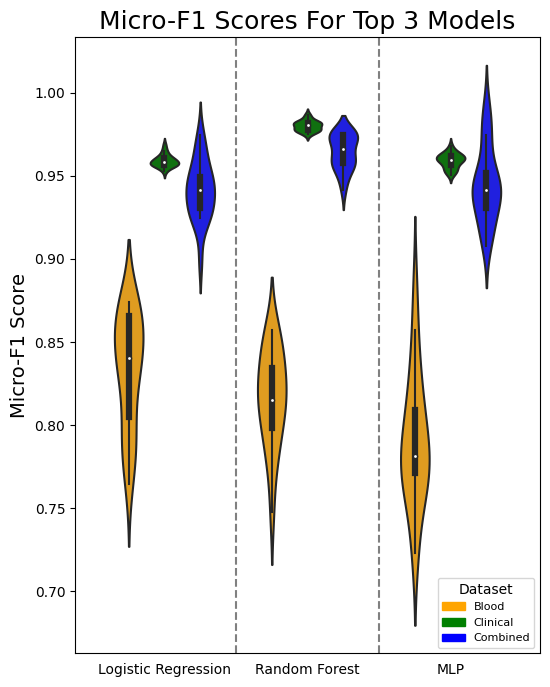

In [28]:
plot_f1_scores(
    [
        results["blood_lr_mrmr"]["f1"],
        results["clinical_lr_mrmr"]["f1"],
        results["combined_lr_mrmr"]["f1"],
        results["blood_rf"]["f1"],
        results["clinical_rf"]["f1"],
        results["combined_rf"]["f1"],
        results["blood_mlp_mrmr"]["f1"],
        results["clinical_mlp_mrmr"]["f1"],
        results["combined_mlp_mrmr"]["f1"],
    ],
    title="Micro-F1 Scores For Top 3 Models",
    ylabel="Micro-F1 Score",
    models=["Logistic Regression", "Random Forest", "MLP"],
    pad=3
)

In [29]:
run_elastic_net(clinical_only_mci, num_iters=20, pickle="Clinical LR with MCI")
clinical_lr_mci = evaluate_results("Clinical LR with MCI")

Iteration 0
Best C: 1000.0
Best l1 ratio: 0.2
Micro-F1 score: 0.8454106280193237
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMS3_LMEM2',
       'C1_WMSR_VRII', 'C1_SS_TRAILB', 'F1_PSMSTOTSCR', 'C1_WMSR_LMEM1',
       'C1_WMS3_VRI', 'B5_NPIQINF',
       ...
       'A5_CVAFIB_2.0', 'D1_BRNINJIF_2.0', 'A5_HYPERCHO_2.0', 'A5_THYROID_1.0',
       'A5_CVBYPASS_1.0', 'A3_PROP_PARENTS_DEM_1.0', 'A5_CVANGIO_2.0',
       'A5_HYPERTEN_1.0', 'A5_CANCER_2.0', 'A1_SEX_1.0'],
      dtype='object', length=188)
Confusion matrix:
[[ 937   21   60]
 [  10 1263   92]
 [  67  198  250]]

Iteration 1
Best C: 1000.0
Best l1 ratio: 0.4
Micro-F1 score: 0.8374741200828157
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMS3_LMEM2',
       'C1_WMSR_VRII', 'C1_WMSR_LMEM1', 'AGE', 'C1_WMS3_VRI', 'C1_SS_TRAILB',
       'F1_PSMSTOTSCR',
       ...
       'B1_WEIGHT', 'A5_AUTOIMM_2.0', 'A5_ALCOHOL_1.0', 'D1_BRNINJIF_3.0',
       'A5_PACKSPER_8.0',

In [30]:
run_elastic_net(clinical_only_subset_mci, num_iters=20, pickle="Clinical LR with MCI and MRMR")
clinical_lr_mci_mrmr = evaluate_results("Clinical LR with MCI and MRMR")

Iteration 0
Best C: 1.0
Best l1 ratio: 1
Micro-F1 score: 0.7967563837129055
Feature importances: Index(['F2_IADLTOTSCR', 'A1_HISPANIC_1.0', 'C1_WMS3_LMEM2', 'C1_WMS3_VRI',
       'F1_PSMSTOTSCR', 'B5_NPIQINF', 'AGE', 'C1_WMSR_LMEM2', 'B5_IRRSEV_1.0',
       'C1_WMS3_LMEM1', 'B5_APASEV_3.0', 'A5_INCONTU_1.0', 'B5_DISNSEV_2.0',
       'B5_NITESEV_1.0', 'B5_ANXSEV_1.0', 'B5_DISNSEV_1.0', 'B5_APASEV_2.0',
       'C1_WAIS3_DIGTOT', 'B5_APASEV_1.0', 'B5_MOTSEV_2.0', 'B5_AGITSEV_1.0',
       'B5_ANXSEV_2.0', 'B5_APPSEV_1.0', 'B1_BMI', 'D1_NEOPIF_3.0',
       'B5_MOTSEV_1.0', 'B5_DELSEV_1.0', 'B5_APPSEV_2.0', 'B5_AGITSEV_2.0',
       'A5_DEP2YRS_1.0', 'B5_DEPDSEV_1.0', 'B5_NITESEV_2.0', 'C1_SS_TRAILA',
       'C1_SS_TRAILB', 'B5_IRRSEV_2.0', 'C1_WMSR_DIGTOT'],
      dtype='object')
Confusion matrix:
[[ 840   51   46]
 [  16 1282  116]
 [  92  268  187]]

Iteration 1
Best C: 1000.0
Best l1 ratio: 0
Micro-F1 score: 0.795376121463078
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMS3_VRI', 'C1

## Feature Selection Plots

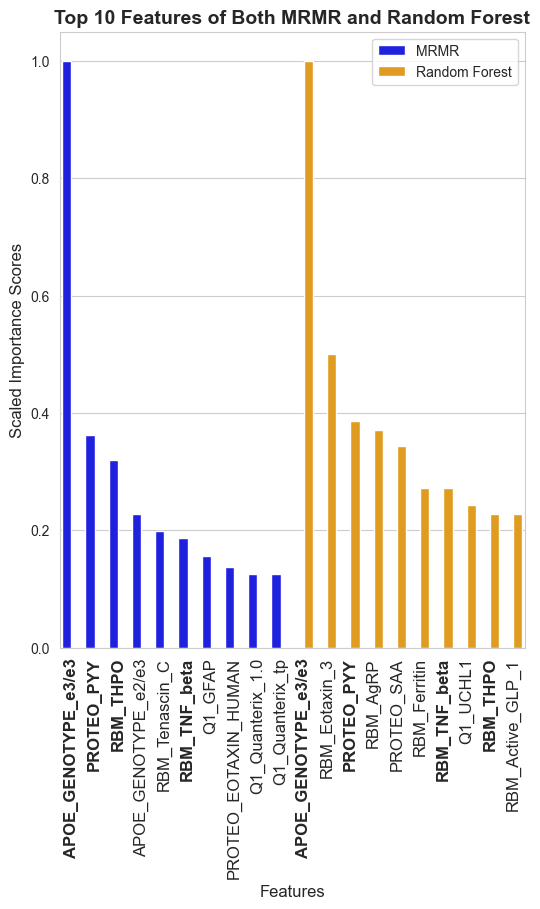

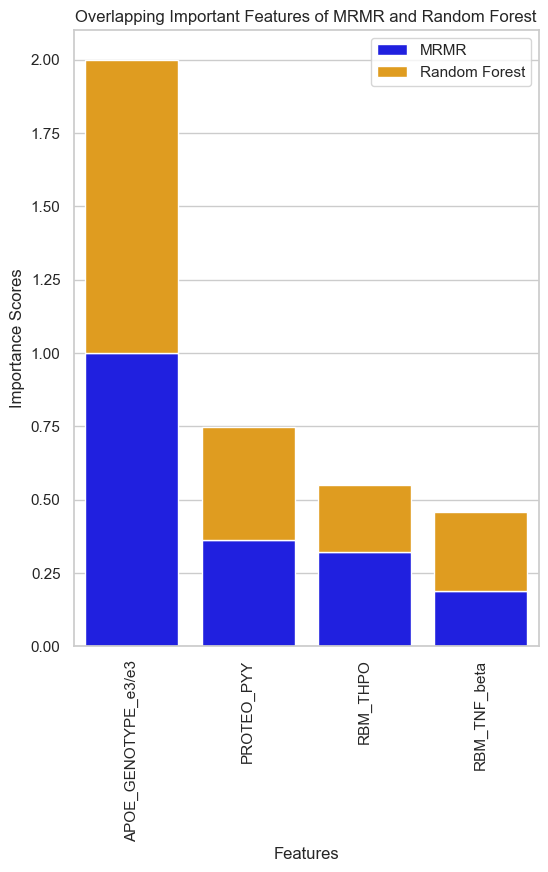

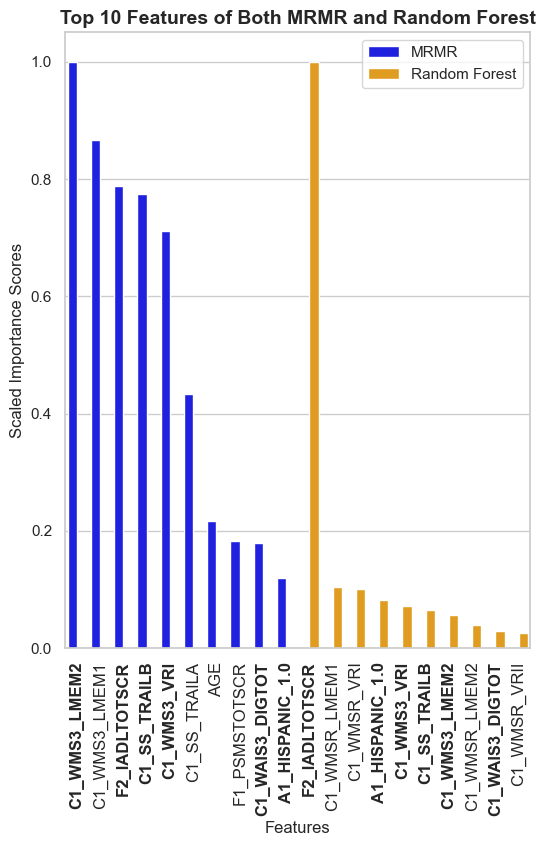

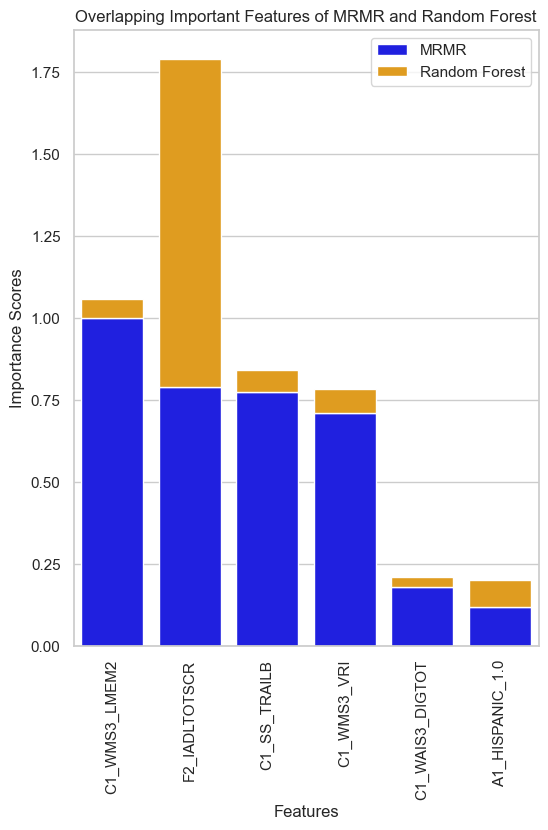

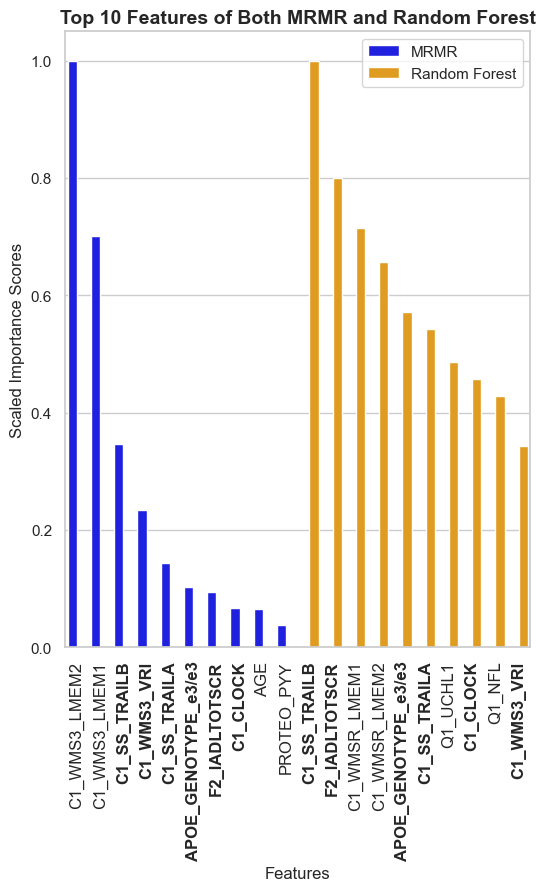

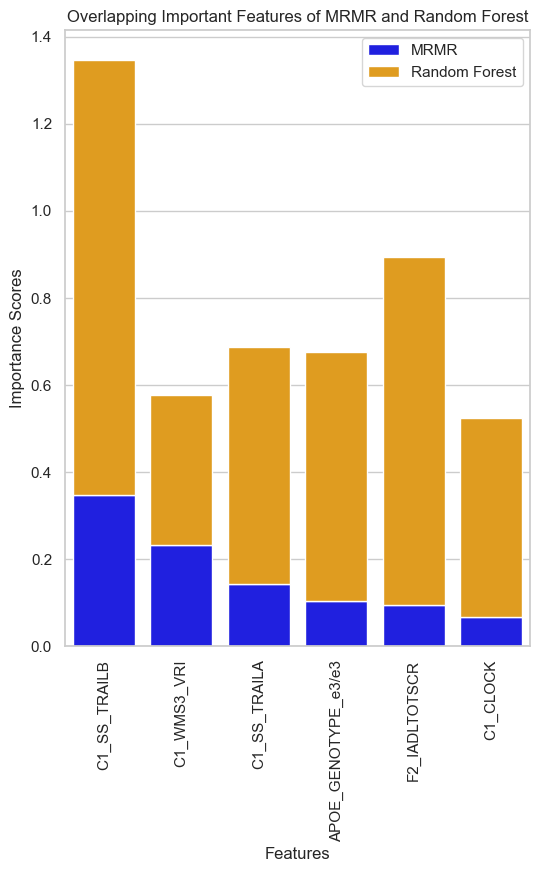

In [31]:
blood_rf_scores, blood_rf_features = results["blood_rf"]["importance"], results["blood_rf"]["features"]
clinical_rf_scores, clinical_rf_features = results["clinical_rf"]["importance"], results["clinical_rf"]["features"]
combined_rf_scores, combined_rf_features = results["combined_rf"]["importance"], results["combined_rf"]["features"]

plot_mrmr_and_rf(blood_mrmr_scores, blood_rf_scores, blood_rf_features)
plot_mrmr_and_rf(clinical_mrmr_scores, clinical_rf_scores, clinical_rf_features)
plot_mrmr_and_rf(combined_mrmr_scores, combined_rf_scores, combined_rf_features)